In [1]:
# =========================
# IMPORTS
# =========================
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
from pathlib import Path

# =========================
# CONFIG
# =========================
ANCHO, ALTO = 35, 20
N_COLS, N_ROWS = 3, 3
MIS_JUGADORES = ["Vicente", "Brandon", "Zurdo", "Bruno", "JuanBe", "Toto", "Vito", "Fido", "Vicen", "Pepo", "Mateo"]

# =========================
# KEYWORDS (lower)
# =========================
KW_TOTAL   = [k.lower() for k in ["pase","recuperacion","recuperación","perdida","pérdida","pierde",
                                  "conseguido","faltas","centro","lateral","despeje","despeje rival",
                                  "gira","aguanta","cpie","cmano"]]
KW_PERDIDA = [k.lower() for k in ["perdida","pérdida","pierde","despeje"]]
KW_RECU    = [k.lower() for k in ["recuperacion","recuperación","1v1 ganado","despeje rival","cpie","cmano"]]

# =========================
# HELPERS BÁSICOS
# =========================
def cargar_datos_nacsport(xml_path: Path) -> pd.DataFrame:
    root = ET.parse(xml_path).getroot()
    data = []
    for inst in root.findall(".//instance"):
        jugador = inst.findtext("code")
        pos_x = [float(px.text) for px in inst.findall("pos_x")]
        pos_y = [float(py.text) for py in inst.findall("pos_y")]
        labels = [lbl.findtext("text") for lbl in inst.findall("label")]
        data.append({"jugador": jugador, "labels": labels, "pos_x_list": pos_x, "pos_y_list": pos_y})
    return pd.DataFrame(data)

def es_mi_equipo(jugador: str) -> bool:
    return jugador is not None and any(n in jugador for n in MIS_JUGADORES)

def es_rival(jugador: str) -> bool:
    return jugador == "Categoria - Equipo Rival"

def instancia_valida(jugador: str) -> bool:
    if jugador is None:
        return False
    excluidos = ("Tiempo No Jugado", "Tiempo Posecion Ferro", "Tiempo Posecion Rival")
    return not any(e in jugador for e in excluidos)

def normaliza_labels(labels): return [l.lower() for l in labels if l]
def contiene(labels_low, keywords_low): return any(k in l for l in labels_low for k in keywords_low)

def rol_de(jugador: str) -> str | None:
    if jugador and "(" in jugador and ")" in jugador:
        return jugador.split("(")[1].split(")")[0].strip()
    return None

def transformar_xy(px, py):
    # Nacsport -> cancha 35x20
    return ANCHO - (py * (ANCHO / 40.0)), px

def ajustar_ala(y_campo, jugador):
    # Ala I arriba, Ala D abajo
    if rol_de(jugador) in ("Ala I", "Ala D"):
        return ALTO - y_campo
    return y_campo

def zona_from_xy(x, y):
    dx, dy = ANCHO / N_COLS, ALTO / N_ROWS
    col = min(int(x // dx), N_COLS - 1)
    row = min(int(y // dy), N_ROWS - 1)
    return row, col

def zona_id(row, col): return row * N_COLS + col + 1

def get_point(pxs, pys, idx):
    if not pxs: return None
    idx = max(0, min(idx, len(pxs) - 1))
    return pxs[idx], pys[idx]

def zone_for_event(jugador, pxs, pys, event: str):
    """
    event in {"PERDIDA","RECUPERACION"}.
      - PERDIDA: mío -> idx 1 si hay, si no 0 ; rival -> idx 0
      - RECUPERACION: mío -> idx 0 ; rival -> idx 1 si hay, si no 0
    """
    if event == "PERDIDA":
        idx = 1 if es_mi_equipo(jugador) and len(pxs) > 1 else 0
    else:
        idx = 0 if es_mi_equipo(jugador) else (1 if len(pxs) > 1 else 0)

    p = get_point(pxs, pys, idx)
    if p is None: return None
    x, y = transformar_xy(*p)
    if es_mi_equipo(jugador): y = ajustar_ala(y, jugador)
    return zona_from_xy(x, y)

# =========================
# VISUAL DE CANCHA
# =========================
def draw_futsal_pitch_grid(ax):
    dx, dy = ANCHO / N_COLS, ALTO / N_ROWS
    ax.set_facecolor("white")
    # bordes + media
    ax.plot([0, ANCHO], [0, 0], color="black")
    ax.plot([0, ANCHO], [ALTO, ALTO], color="black")
    ax.plot([0, 0], [0, ALTO], color="black")
    ax.plot([ANCHO, ANCHO], [0, ALTO], color="black")
    ax.plot([ANCHO/2, ANCHO/2], [0, ALTO], color="black")
    # áreas y círculo central
    ax.add_patch(Arc((0, ALTO/2), 8, 12, angle=0, theta1=270, theta2=90, color="black"))
    ax.add_patch(Arc((ANCHO, ALTO/2), 8, 12, angle=0, theta1=90, theta2=270, color="black"))
    ax.add_patch(plt.Circle((ANCHO/2, ALTO/2), 4, color="black", fill=False))
    ax.add_patch(plt.Circle((ANCHO/2, ALTO/2), 0.2, color="black"))
    # grilla + numeración
    for j in range(N_ROWS):
        for i in range(N_COLS):
            x0, y0 = i * dx, j * dy
            ax.add_patch(Rectangle((x0, y0), dx, dy, linewidth=0.6, edgecolor='gray', facecolor='none'))
            ax.text(x0 + dx - 0.4, y0 + dy - 0.4, str(zona_id(j, i)), ha='right', va='top', fontsize=9, color='gray')
    ax.set_xlim(0, ANCHO); ax.set_ylim(0, ALTO); ax.axis('off')

def plot_mapa(porcentaje, total_acciones, title):
    fig, ax = plt.subplots(figsize=(9, 6))
    draw_futsal_pitch_grid(ax)
    cmap = LinearSegmentedColormap.from_list("mapa", ["#f0f9e8","#bae4bc","#7bccc4","#2b8cbe","#08589e"])
    dx, dy = ANCHO / N_COLS, ALTO / N_ROWS
    for i in range(N_COLS):
        for j in range(N_ROWS):
            val = porcentaje[j, i]
            color = cmap(val) if total_acciones[j, i] > 0 else (1, 1, 1, 0)
            ax.add_patch(Rectangle((i*dx, j*dy), dx, dy, color=color, alpha=0.6))
            ax.text(i*dx + dx/2, j*dy + dy/2, f"{val*100:.1f}%", fontsize=11, ha='center', va='center', color='black', fontweight='bold')
    plt.title(title); plt.tight_layout(); plt.show()

# =========================
# CORE: PROCESAR (equipo)
# =========================
def procesar(df_raw: pd.DataFrame, allow_both=True):
    """
    total_acc = perdidas + recupera + otros.
    Evita doble conteo: si una instancia es PÉRDIDA o RECUPERACIÓN, no suma en 'otros'.
    allow_both=True -> si una instancia trae ambos labels, cuenta ambos.
    """
    total_acc = np.zeros((N_ROWS, N_COLS), dtype=int)
    perdidas  = np.zeros((N_ROWS, N_COLS), dtype=int)
    recupera  = np.zeros((N_ROWS, N_COLS), dtype=int)
    registros = []

    for _, row in df_raw.iterrows():
        jugador = row["jugador"]
        if not instancia_valida(jugador): continue
        labels_low = normaliza_labels(row["labels"])
        pxs, pys = row["pos_x_list"], row["pos_y_list"]
        if not pxs: continue

        es_mio = es_mi_equipo(jugador)
        es_riv = es_rival(jugador)
        de_interes = (es_mio or es_riv) and contiene(labels_low, KW_TOTAL)
        has_perd = contiene(labels_low, KW_PERDIDA)
        has_recu = contiene(labels_low, KW_RECU)

        counted_any = False

        if has_perd:
            z = zone_for_event(jugador, pxs, pys, "PERDIDA")
            if z is not None:
                r, c = z
                perdidas[r, c] += 1
                total_acc[r, c] += 1
                counted_any = True
                registros.append((r, c, zona_id(r, c), jugador, labels_low, "PÉRDIDA"))

        if has_recu and (allow_both or not counted_any):
            z = zone_for_event(jugador, pxs, pys, "RECUPERACION")
            if z is not None:
                r, c = z
                recupera[r, c] += 1
                total_acc[r, c] += 1
                counted_any = True
                registros.append((r, c, zona_id(r, c), jugador, labels_low, "RECUPERACIÓN"))

        if (not counted_any) and de_interes:
            p = get_point(pxs, pys, 0)
            if p is None: continue
            x, y = transformar_xy(*p)
            if es_mio: y = ajustar_ala(y, jugador)
            r, c = zona_from_xy(x, y)
            total_acc[r, c] += 1
            registros.append((r, c, zona_id(r, c), jugador, labels_low, "OTROS"))

    with np.errstate(divide='ignore', invalid='ignore'):
        porc_perd = np.divide(perdidas, total_acc, out=np.zeros_like(perdidas, dtype=float), where=total_acc > 0)
        porc_recu = np.divide(recupera, total_acc, out=np.zeros_like(recupera, dtype=float), where=total_acc > 0)

    df_reg = pd.DataFrame(registros, columns=["row","col","zona","jugador","labels_low","tipo"])

    resumen = []
    for r in range(N_ROWS):
        for c in range(N_COLS):
            t = int(total_acc[r, c]); p = int(perdidas[r, c]); rc = int(recupera[r, c])
            resumen.append({
                "zona": zona_id(r, c), "row": r, "col": c,
                "total_acciones": t, "perdidas": p, "recuperaciones": rc,
                "%_perdidas_sobre_total": (p / t) if t else 0.0,
                "%_recuperaciones_sobre_total": (rc / t) if t else 0.0
            })
    df_resumen_zona = pd.DataFrame(resumen).sort_values("zona").reset_index(drop=True)

    return total_acc, perdidas, recupera, porc_perd, porc_recu, df_reg, df_resumen_zona

# =========================
# MAPAS DIVERGENTES (equipo)
# =========================
def _robust_min_max(mat, q_low=0.10, q_high=0.90):
    vals = mat[np.isfinite(mat)]
    if vals.size == 0: return 0.0, 1.0
    lo = np.quantile(vals, q_low); hi = np.quantile(vals, q_high)
    if np.isclose(hi, lo): hi = lo + 1e-9
    return lo, hi
def _norm_clamp(mat, lo, hi): return np.clip((mat - lo) / (hi - lo), 0.0, 1.0)

def plot_mapa_divergente(porcentaje, total_acciones, title,
                         good_high=True, min_actions=5,
                         q_low=0.10, q_high=0.90):
    fig, ax = plt.subplots(figsize=(9, 6))
    draw_futsal_pitch_grid(ax)

    data = porcentaje.copy()
    if not good_high: data = 1.0 - data
    lo, hi = _robust_min_max(data, q_low, q_high)
    data_n = _norm_clamp(data, lo, hi)
    cmap = LinearSegmentedColormap.from_list("rdylgn", ["#b2182b","#f7f7f7","#1a9850"])
    dx, dy = ANCHO / N_COLS, ALTO / N_ROWS
    for i in range(N_COLS):
        for j in range(N_ROWS):
            tot = int(total_acciones[j, i])
            if tot < min_actions or not np.isfinite(data_n[j, i]):
                color = (0.9, 0.9, 0.9, 0.35); txt = f"Tot<{min_actions}"
            else:
                color = cmap(data_n[j, i]); txt = f"{porcentaje[j, i]*100:.1f}%"
            ax.add_patch(Rectangle((i*dx, j*dy), dx, dy, color=color, alpha=0.65))
            ax.text(i*dx + dx/2, j*dy + dy/2, txt, ha='center', va='center',
                    fontsize=11, color='black', fontweight='bold')
            ax.text(i*dx + dx - 0.2, j*dy + 0.2, f"Tot: {tot}",
                    ha='right', va='bottom', fontsize=8, color='black')
    plt.title(title); plt.tight_layout(); plt.show()

# =========================
# RANKINGS (equipo)
# =========================
def _fmt_pct(x, pos):
    return f"{x*100:.0f}%"

def _barh_with_labels(ax, labels, values, totals, title):
    ax.barh(labels, values, height=0.6)
    ax.set_title(title, pad=10)
    ax.xaxis.set_major_formatter(FuncFormatter(_fmt_pct))
    ax.grid(axis="x", linestyle=":", alpha=0.35)
    ax.invert_yaxis()

    # margen visual corto para no “agrandar” mucho el eje
    vmax = max(values) if len(values) else 0.01
    xpad = vmax * 0.05
    ax.set_xlim(0, vmax + xpad)

    x_right = ax.get_xlim()[1]

    for y, v, tot in zip(range(len(labels)), values, totals):
        txt = f"{v*100:.1f}%  (Tot {int(tot)})"

        near_right = v >= x_right * 0.88     # muy cerca del borde derecho
        big_bar   = v >= x_right * 0.12      # barra “grande”
        tiny_bar  = v <= x_right * 0.04      # barra muy chica

        if near_right or big_bar:
            # etiqueta DENTRO de la barra (alineada a la derecha)
            ax.text(v - x_right*0.01, y, txt,
                    va="center", ha="right", fontsize=9,
                    color="white", fontweight="bold")
        elif tiny_bar:
            # barra enana: poner texto apenas afuera, con padding corto
            ax.text(min(v + x_right*0.012, x_right - x_right*0.005), y, txt,
                    va="center", ha="left", fontsize=8, color="black")
        else:
            # barra media: afuera con padding moderado
            ax.text(min(v + x_right*0.008, x_right - x_right*0.005), y, txt,
                    va="center", ha="left", fontsize=9, color="black")

def plot_rankings(df_resumen_zona, top_n=9):
    dfp = df_resumen_zona.copy()
    dfp["%_perd"] = dfp["%_perdidas_sobre_total"].astype(float)
    dfp["%_recu"] = dfp["%_recuperaciones_sobre_total"].astype(float)

    perd = dfp.sort_values("%_perd", ascending=False).head(top_n)[["zona","%_perd","total_acciones"]]
    recu = dfp.sort_values("%_recu", ascending=False).head(top_n)[["zona","%_recu","total_acciones"]]

    labels_perd = [f"Z{z}" for z in perd["zona"]]; vals_perd = perd["%_perd"].to_list(); tots_perd = perd["total_acciones"].to_list()
    labels_recu = [f"Z{z}" for z in recu["zona"]]; vals_recu = recu["%_recu"].to_list(); tots_recu = recu["total_acciones"].to_list()

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), constrained_layout=False)
    plt.subplots_adjust(top=0.90, bottom=0.08, left=0.18, right=0.96, hspace=0.35)
    _barh_with_labels(ax1, labels_perd, vals_perd, tots_perd, "Ranking Zonas — % PÉRDIDAS (peor → mejor)")
    _barh_with_labels(ax2, labels_recu, vals_recu, tots_recu, "Ranking Zonas — % RECUPERACIONES (mejor → peor)")
    fig.suptitle("Zonas 3×3 — Porcentaje y volumen por zona", fontsize=12, y=0.98)
    plt.show()

# =========================
# POR JUGADOR
# =========================
def _match_jugador(jugador_str: str, nombre: str) -> bool:
    return (jugador_str is not None) and (nombre.lower() in jugador_str.lower())

def resumen_por_jugador_zona(df_reg: pd.DataFrame, total_acc: np.ndarray, nombre_jugador: str) -> pd.DataFrame:
    if df_reg.empty:
        return pd.DataFrame(columns=["zona","row","col","jugador_acciones","jugador_perdidas","jugador_recuperaciones",
                                     "%_perdidas_sobre_acc_jugador","%_recuperaciones_sobre_acc_jugador",
                                     "total_zona","%_perdidas_sobre_total_zona","%_recuperaciones_sobre_total_zona"])

    df_p = df_reg[df_reg["jugador"].apply(lambda s: _match_jugador(s, nombre_jugador))].copy()
    if df_p.empty:
        return pd.DataFrame(columns=["zona","row","col","jugador_acciones","jugador_perdidas","jugador_recuperaciones",
                                     "%_perdidas_sobre_acc_jugador","%_recuperaciones_sobre_acc_jugador",
                                     "total_zona","%_perdidas_sobre_total_zona","%_recuperaciones_sobre_total_zona"])

    agg = (df_p.groupby(["zona","row","col","tipo"], as_index=False).size()
              .pivot(index=["zona","row","col"], columns="tipo", values="size").fillna(0).reset_index())

    for col in ["PÉRDIDA","RECUPERACIÓN","OTROS"]:
        if col not in agg.columns: agg[col] = 0

    agg["jugador_perdidas"] = agg["PÉRDIDA"].astype(int)
    agg["jugador_recuperaciones"] = agg["RECUPERACIÓN"].astype(int)
    agg["jugador_acciones"] = (agg["PÉRDIDA"] + agg["RECUPERACIÓN"] + agg["OTROS"]).astype(int)

    agg["%_perdidas_sobre_acc_jugador"] = np.where(agg["jugador_acciones"] > 0,
                                                   agg["jugador_perdidas"] / agg["jugador_acciones"], 0.0)
    agg["%_recuperaciones_sobre_acc_jugador"] = np.where(agg["jugador_acciones"] > 0,
                                                         agg["jugador_recuperaciones"] / agg["jugador_acciones"], 0.0)

    def _total_zona(row):
        r, c = int(row["row"]), int(row["col"])
        return int(total_acc[r, c]) if 0 <= r < total_acc.shape[0] and 0 <= c < total_acc.shape[1] else 0
    agg["total_zona"] = agg.apply(_total_zona, axis=1)

    agg["%_perdidas_sobre_total_zona"] = np.where(agg["total_zona"] > 0,
                                                  agg["jugador_perdidas"] / agg["total_zona"], 0.0)
    agg["%_recuperaciones_sobre_total_zona"] = np.where(agg["total_zona"] > 0,
                                                        agg["jugador_recuperaciones"] / agg["total_zona"], 0.0)

    cols = ["zona","row","col","jugador_acciones","jugador_perdidas","jugador_recuperaciones",
            "%_perdidas_sobre_acc_jugador","%_recuperaciones_sobre_acc_jugador",
            "total_zona","%_perdidas_sobre_total_zona","%_recuperaciones_sobre_total_zona"]
    return agg[cols].sort_values("zona").reset_index(drop=True)

# Matrices para jugador
def matriz_from_df_jugador(df_j, campo, n_rows=N_ROWS, n_cols=N_COLS):
    m = np.zeros((n_rows, n_cols), dtype=float)
    for _, r in df_j.iterrows(): m[int(r["row"]), int(r["col"])] = float(r[campo])
    return m
def matriz_volume_jugador(df_j, campo="jugador_acciones", n_rows=N_ROWS, n_cols=N_COLS):
    m = np.zeros((n_rows, n_cols), dtype=int)
    for _, r in df_j.iterrows(): m[int(r["row"]), int(r["col"])] = int(r[campo])
    return m

# Mapa divergente por jugador (con Tot/ Tot<k)
def plot_mapa_divergente_jugador(percent_matrix, volumen_jugador_matrix, title,
                                 good_high=True, min_actions_player=2,
                                 q_low=0.10, q_high=0.90):
    fig, ax = plt.subplots(figsize=(9, 6))
    draw_futsal_pitch_grid(ax)

    data = percent_matrix.copy()
    if not good_high: data = 1.0 - data
    lo, hi = _robust_min_max(data, q_low, q_high)
    data_n = _norm_clamp(data, lo, hi)
    cmap = LinearSegmentedColormap.from_list("rdylgn", ["#b2182b","#f7f7f7","#1a9850"])
    dx, dy = ANCHO / N_COLS, ALTO / N_ROWS

    for i in range(N_COLS):
        for j in range(N_ROWS):
            tot_j = int(volumen_jugador_matrix[j, i])
            if tot_j < min_actions_player or not np.isfinite(data_n[j, i]):
                color = (0.9, 0.9, 0.9, 0.35); txt = f"Tot<{min_actions_player}"
            else:
                color = cmap(data_n[j, i]); txt = f"{percent_matrix[j, i]*100:.1f}%"
            ax.add_patch(Rectangle((i*dx, j*dy), dx, dy, color=color, alpha=0.65))
            ax.text(i*dx + dx/2, j*dy + dy/2, txt, ha='center', va='center',
                    fontsize=11, color='black', fontweight='bold')
            ax.text(i*dx + dx - 0.2, j*dy + 0.2, f"Tot: {tot_j}",
                    ha='right', va='bottom', fontsize=8, color='black')
    plt.title(title); plt.tight_layout(); plt.show()

# Rankings por jugador
def plot_rankings_jugador(df_j, modo="ambos"):
    df = df_j.copy()
    df["p_perd_eff"] = df["%_perdidas_sobre_acc_jugador"].astype(float)
    df["p_recu_eff"] = df["%_recuperaciones_sobre_acc_jugador"].astype(float)
    df["p_perd_imp"] = df["%_perdidas_sobre_total_zona"].astype(float)
    df["p_recu_imp"] = df["%_recuperaciones_sobre_total_zona"].astype(float)

    zones = [f"Z{z}" for z in df["zona"]]
    panels = []
    if modo in ("ambos","eficiencia"):
        d1 = df.sort_values("p_perd_eff", ascending=False)
        d2 = df.sort_values("p_recu_eff", ascending=False)
        panels.append(("Eficiencia — % PÉRDIDAS (↓ mejor)", [f"Z{z}" for z in d1["zona"]],
                       d1["p_perd_eff"].to_list(), d1["jugador_acciones"].to_list()))
        panels.append(("Eficiencia — % RECUPERACIONES (↑ mejor)", [f"Z{z}" for z in d2["zona"]],
                       d2["p_recu_eff"].to_list(), d2["jugador_acciones"].to_list()))
    if modo in ("ambos","impacto"):
        d3 = df.sort_values("p_perd_imp", ascending=False)
        d4 = df.sort_values("p_recu_imp", ascending=False)
        panels.append(("Impacto — % PÉRDIDAS s/total zona", [f"Z{z}" for z in d3["zona"]],
                       d3["p_perd_imp"].to_list(), d3["total_zona"].to_list()))
        panels.append(("Impacto — % RECUPERACIONES s/total zona", [f"Z{z}" for z in d4["zona"]],
                       d4["p_recu_imp"].to_list(), d4["total_zona"].to_list()))

    fig, axes = plt.subplots(nrows=len(panels), ncols=1, figsize=(8, 3.2*len(panels)), constrained_layout=False)
    if len(panels)==1: axes = [axes]
    plt.subplots_adjust(top=0.95, bottom=0.07, left=0.20, right=0.96, hspace=0.35)
    for ax, (title, lbls, vals, tots) in zip(axes, panels):
        _barh_with_labels(ax, lbls, vals, tots, title)
    fig.suptitle("Resumen por zona — Jugador", fontsize=12, y=0.99)
    plt.show()

# Índice combinado por jugador + ranking
def indice_combinado_jugador(df_j: pd.DataFrame, modo="eff", w_recu=0.6, w_perd=0.4) -> pd.DataFrame:
    df = df_j.copy()
    if modo == "imp":
        recu = df["%_recuperaciones_sobre_total_zona"].astype(float).fillna(0)
        perd = df["%_perdidas_sobre_total_zona"].astype(float).fillna(0)
    else:
        recu = df["%_recuperaciones_sobre_acc_jugador"].astype(float).fillna(0)
        perd = df["%_perdidas_sobre_acc_jugador"].astype(float).fillna(0)
    df["idx"] = w_recu * recu + w_perd * (1.0 - perd)
    return df

def plot_ranking_indice_jugador(df_idx: pd.DataFrame, titulo="Índice combinado (↑ mejor)"):
    orden = df_idx.sort_values("idx", ascending=False)
    labels = [f"Z{z}" for z in orden["zona"]]
    vals   = orden["idx"].to_list()
    tots   = orden["jugador_acciones"].to_list()
    fig, ax = plt.subplots(figsize=(8, max(3.2, 0.35*len(labels) + 2)))
    _barh_with_labels(ax, labels, vals, tots, titulo)
    plt.show()

def plot_mapa_indice_estrellas(percent_matrix, title="Índice combinado — mejor⭐ / peor🔻"):
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = plt.cm.RdYlGn
    im = ax.imshow(percent_matrix, cmap=cmap, vmin=0, vmax=1)
    best_idx = np.unravel_index(np.argmax(percent_matrix), percent_matrix.shape)
    worst_idx = np.unravel_index(np.argmin(percent_matrix), percent_matrix.shape)
    for i in range(percent_matrix.shape[0]):
        for j in range(percent_matrix.shape[1]):
            ax.text(j, i, f"{percent_matrix[i, j]*100:.1f}%", ha="center", va="center", fontsize=9)
    ax.scatter(best_idx[1], best_idx[0], marker="*", s=300, color="gold", edgecolors="black", linewidths=1.5, zorder=3)
    ax.scatter(worst_idx[1], worst_idx[0], marker="v", s=200, color="red", edgecolors="black", linewidths=1.5, zorder=3)
    ax.set_xticks(range(percent_matrix.shape[1])); ax.set_yticks(range(percent_matrix.shape[0]))
    ax.set_xticklabels([f"Col {i+1}" for i in range(percent_matrix.shape[1])])
    ax.set_yticklabels([f"Row {i+1}" for i in range(percent_matrix.shape[0])])
    ax.set_title(title, fontsize=12, fontweight="bold")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Índice")
    plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()

# =========================
# EJEMPLO DE USO (AJUSTÁ RUTA)
# =========================
#Montamos el drive de Google
from google.colab import drive
drive.mount('/content/drive/')

# Ruta base donde está el archivo
ruta_base = Path('/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores')

xml_file = ruta_base / "Union Ezpeleta - XML NacSport.xml"
df_raw = cargar_datos_nacsport(xml_file)
total_acc, perdidas, recupera, porc_perd, porc_recu, df_registros, df_resumen_zona = procesar(df_raw)


Mounted at /content/drive/


In [2]:
# # Por jugador (ejemplo: Pepo)
df_pepo = resumen_por_jugador_zona(df_registros, total_acc, nombre_jugador="Bruno")


In [3]:
mat_perd_eff = matriz_from_df_jugador(df_pepo, "%_perdidas_sobre_acc_jugador")
mat_recu_eff = matriz_from_df_jugador(df_pepo, "%_recuperaciones_sobre_acc_jugador")
mat_vol_j = matriz_volume_jugador(df_pepo, "jugador_acciones")


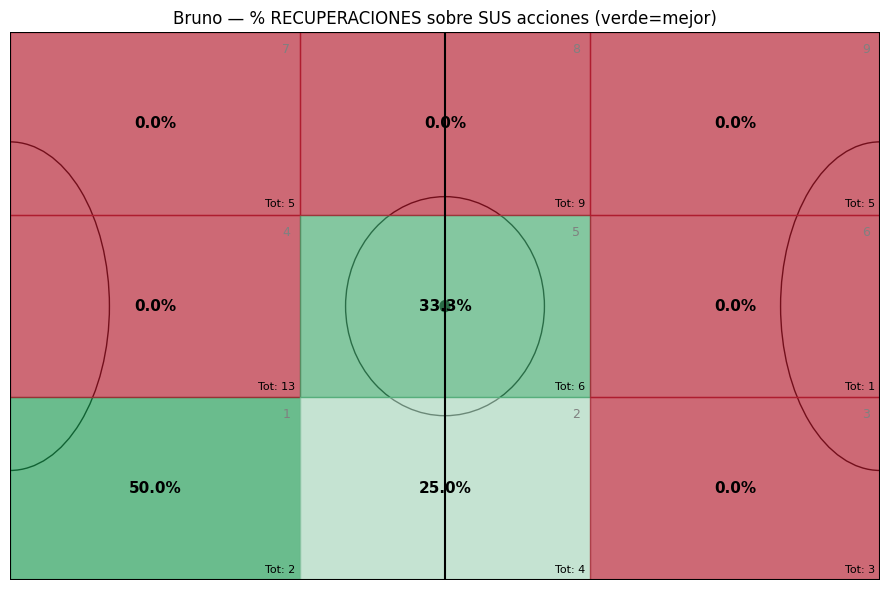

In [4]:
plot_mapa_divergente_jugador(mat_recu_eff, mat_vol_j, "Bruno — % RECUPERACIONES sobre SUS acciones (verde=mejor)", good_high=True,  min_actions_player=0)


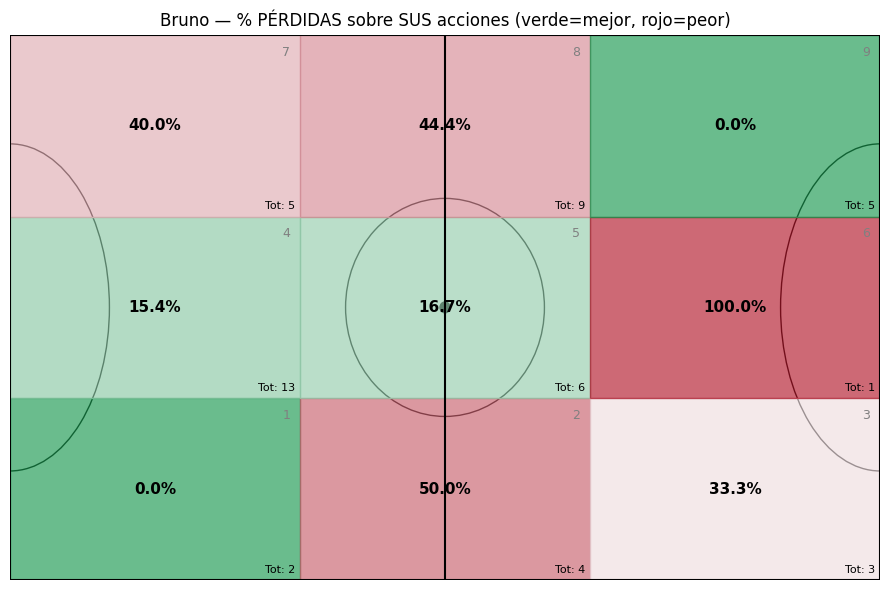

In [5]:
plot_mapa_divergente_jugador(mat_perd_eff, mat_vol_j, "Bruno — % PÉRDIDAS sobre SUS acciones (verde=mejor, rojo=peor)", good_high=False, min_actions_player=0)


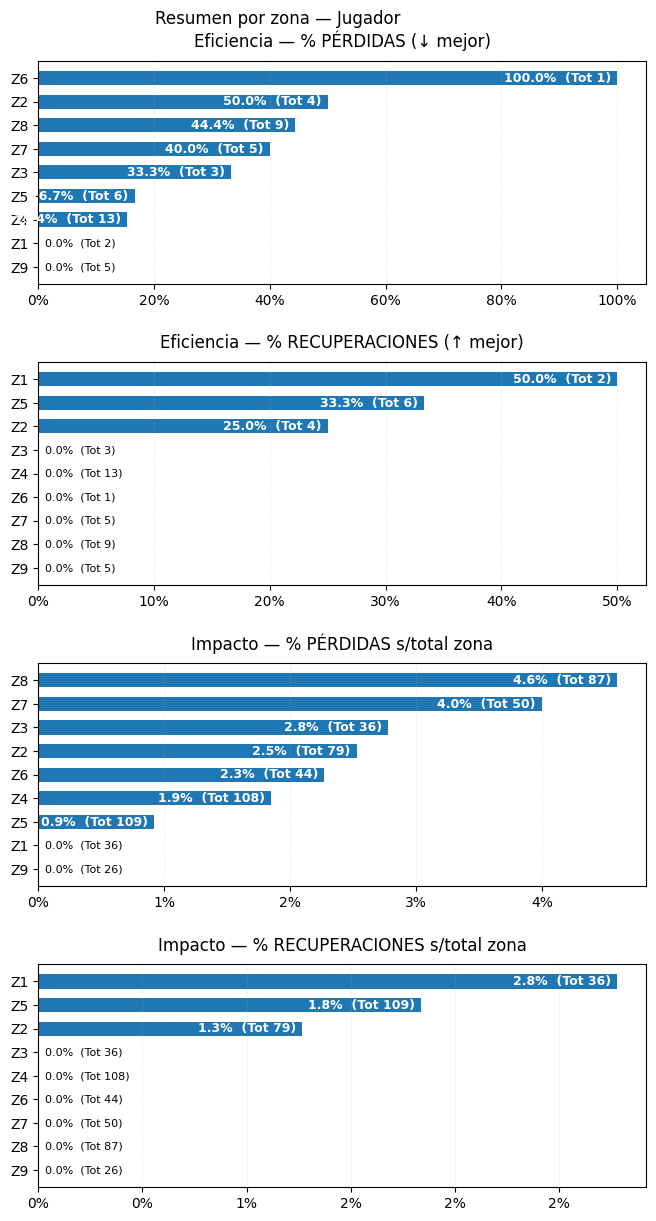

In [6]:
plot_rankings_jugador(df_pepo, modo="ambos")

In [7]:
def _coerce_player_summary(df_source, nombre_jugador=None, total_acc=None):
    """
    Devuelve un df resumen por zona con columnas:
      ['zona','row','col','jugador_acciones','jugador_perdidas','jugador_recuperaciones',
       '%_perdidas_sobre_acc_jugador','%_recuperaciones_sobre_acc_jugador',
       'total_zona','%_perdidas_sobre_total_zona','%_recuperaciones_sobre_total_zona']
    Acepta:
      - df ya resumido (contiene 'jugador_acciones') -> lo devuelve tal cual
      - df de eventos (como df_registros) -> lo resume internamente (requiere nombre_jugador)
    """
    needed_cols = {"jugador_acciones","%_perdidas_sobre_acc_jugador","%_recuperaciones_sobre_acc_jugador"}
    if needed_cols.issubset(df_source.columns):
        # Ya es resumen por zona
        return df_source.copy()

    # Caso: df de eventos
    if not {"zona","row","col","tipo","jugador"}.issubset(df_source.columns):
        raise ValueError("El DataFrame no parece ni resumen ni eventos (faltan columnas clave).")

    if not nombre_jugador:
        raise ValueError("Para resumir eventos necesito nombre_jugador (match por contains).")

    # Filtramos eventos del jugador
    df_p = df_source[df_source["jugador"].str.contains(nombre_jugador, case=False, na=False)].copy()
    if df_p.empty:
        # devolvemos marco vacío con el esquema esperado
        return pd.DataFrame(columns=[
            "zona","row","col","jugador_acciones","jugador_perdidas","jugador_recuperaciones",
            "%_perdidas_sobre_acc_jugador","%_recuperaciones_sobre_acc_jugador",
            "total_zona","%_perdidas_sobre_total_zona","%_recuperaciones_sobre_total_zona"
        ])

    agg = (df_p.groupby(["zona","row","col","tipo"], as_index=False)
              .size()
              .pivot(index=["zona","row","col"], columns="tipo", values="size")
              .fillna(0).reset_index())

    for col in ["PÉRDIDA","RECUPERACIÓN","OTROS"]:
        if col not in agg.columns: agg[col] = 0

    agg["jugador_perdidas"]        = agg["PÉRDIDA"].astype(int)
    agg["jugador_recuperaciones"]  = agg["RECUPERACIÓN"].astype(int)
    agg["jugador_acciones"]        = (agg["PÉRDIDA"] + agg["RECUPERACIÓN"] + agg["OTROS"]).astype(int)

    # % sobre acciones del jugador
    agg["%_perdidas_sobre_acc_jugador"]       = np.where(agg["jugador_acciones"]>0, agg["jugador_perdidas"]/agg["jugador_acciones"], 0.0)
    agg["%_recuperaciones_sobre_acc_jugador"] = np.where(agg["jugador_acciones"]>0, agg["jugador_recuperaciones"]/agg["jugador_acciones"], 0.0)

    # total_zona (si tenemos matriz total_acc); si no, lo igualo al volumen del jugador para que el scatter funcione
    if total_acc is not None:
        def _tz(r):
            rr, cc = int(r["row"]), int(r["col"])
            return int(total_acc[rr, cc]) if 0 <= rr < total_acc.shape[0] and 0 <= cc < total_acc.shape[1] else 0
        agg["total_zona"] = agg.apply(_tz, axis=1)
    else:
        agg["total_zona"] = agg["jugador_acciones"].astype(int)

    agg["%_perdidas_sobre_total_zona"]       = np.where(agg["total_zona"]>0, agg["jugador_perdidas"]/agg["total_zona"], 0.0)
    agg["%_recuperaciones_sobre_total_zona"] = np.where(agg["total_zona"]>0, agg["jugador_recuperaciones"]/agg["total_zona"], 0.0)

    cols = ["zona","row","col","jugador_acciones","jugador_perdidas","jugador_recuperaciones",
            "%_perdidas_sobre_acc_jugador","%_recuperaciones_sobre_acc_jugador",
            "total_zona","%_perdidas_sobre_total_zona","%_recuperaciones_sobre_total_zona"]
    return agg[cols].sort_values("zona").reset_index(drop=True)


def best_worst_indices(x, y):
    """Mejor = x alto & y bajo; Peor = x bajo & y alto (maneja NaNs)."""
    score = np.asarray(x) - np.asarray(y)
    if np.all(~np.isfinite(score)):
        return 0, 0
    score_best  = np.where(np.isfinite(score), score, -np.inf)
    score_worst = np.where(np.isfinite(score), score,  np.inf)
    return int(np.nanargmax(score_best)), int(np.nanargmin(score_worst))


def plot_scatter_desempeno_jugador(
    df_source,
    nombre_jugador="Jugador",
    modo="eff",
    total_acc=None,
    jitter_edges=True,
    fig_size=(9, 7.5)
):
    """
    Scatter por zona para un jugador.

    Acepta:
      - df_source = df resumen por zona (como df_pepo)  Ó  df de eventos (df_registros)
    Modo:
      - "eff":    X=% recu/acciones jugador | Y=% pérdidas/acciones jugador | size=jugador_acciones
      - "impacto":X=% recu/total zona       | Y=% pérdidas/total zona       | size=total_zona
    """

    # ---- Detectar si es resumen o eventos y normalizar columnas ----
    is_summary = {"jugador_acciones", "%_perdidas_sobre_acc_jugador", "%_recuperaciones_sobre_acc_jugador"}.issubset(df_source.columns)

    if is_summary:
        dfp = df_source.copy()
        # forzar numérico por si vienen strings
        for c in ["jugador_acciones","total_zona",
                  "%_perdidas_sobre_acc_jugador","%_recuperaciones_sobre_acc_jugador",
                  "%_perdidas_sobre_total_zona","%_recuperaciones_sobre_total_zona"]:
            if c in dfp.columns:
                dfp[c] = pd.to_numeric(dfp[c], errors="coerce")
    else:
        # df de eventos -> resumimos acá
        if not {"zona","row","col","tipo","jugador"}.issubset(df_source.columns):
            raise ValueError("df_source no parece ni resumen ni eventos (faltan columnas clave).")

        dfe = df_source[df_source["jugador"].str.contains(nombre_jugador, case=False, na=False)].copy()
        if dfe.empty:
            print("No hay datos para este jugador.")
            return

        agg = (dfe.groupby(["zona","row","col","tipo"], as_index=False).size()
                 .pivot(index=["zona","row","col"], columns="tipo", values="size")
                 .fillna(0).reset_index())
        for col in ["PÉRDIDA","RECUPERACIÓN","OTROS"]:
            if col not in agg.columns: agg[col] = 0

        agg["jugador_perdidas"]       = agg["PÉRDIDA"].astype(int)
        agg["jugador_recuperaciones"] = agg["RECUPERACIÓN"].astype(int)
        agg["jugador_acciones"]       = (agg["PÉRDIDA"] + agg["RECUPERACIÓN"] + agg["OTROS"]).astype(int)

        agg["%_perdidas_sobre_acc_jugador"]       = np.where(agg["jugador_acciones"]>0, agg["jugador_perdidas"]/agg["jugador_acciones"], 0.0)
        agg["%_recuperaciones_sobre_acc_jugador"] = np.where(agg["jugador_acciones"]>0, agg["jugador_recuperaciones"]/agg["jugador_acciones"], 0.0)

        if total_acc is not None:
            def _tz(r):
                rr, cc = int(r["row"]), int(r["col"])
                return int(total_acc[rr, cc]) if 0 <= rr < total_acc.shape[0] and 0 <= cc < total_acc.shape[1] else 0
            agg["total_zona"] = agg.apply(_tz, axis=1)
        else:
            agg["total_zona"] = agg["jugador_acciones"].astype(int)

        agg["%_perdidas_sobre_total_zona"]       = np.where(agg["total_zona"]>0, agg["jugador_perdidas"]/agg["total_zona"], 0.0)
        agg["%_recuperaciones_sobre_total_zona"] = np.where(agg["total_zona"]>0, agg["jugador_recuperaciones"]/agg["total_zona"], 0.0)

        cols = ["zona","row","col","jugador_acciones","jugador_perdidas","jugador_recuperaciones",
                "%_perdidas_sobre_acc_jugador","%_recuperaciones_sobre_acc_jugador",
                "total_zona","%_perdidas_sobre_total_zona","%_recuperaciones_sobre_total_zona"]
        dfp = agg[cols].sort_values("zona").reset_index(drop=True)

    # ---- Selección de columnas según modo ----
    if str(modo).lower() in ("impacto","imp"):
        xcol, ycol, size_col, subt = "%_recuperaciones_sobre_total_zona", "%_perdidas_sobre_total_zona", "total_zona", "Impacto (sobre total de la zona)"
    else:
        xcol, ycol, size_col, subt = "%_recuperaciones_sobre_acc_jugador", "%_perdidas_sobre_acc_jugador", "jugador_acciones", "Eficiencia (sobre acciones del jugador)"

    # Coerción numérica + filtrar sin volumen
    for c in [xcol, ycol, size_col]:
        dfp[c] = pd.to_numeric(dfp[c], errors="coerce")
    dfp = dfp[dfp[size_col].fillna(0) > 0].copy()
    if dfp.empty:
        print("No hay datos para el scatter de este jugador (todas las zonas con 0).")
        return

    # ---- Datos para plot ----
    x = dfp[xcol].to_numpy(dtype=float)
    y = dfp[ycol].to_numpy(dtype=float)
    s = (dfp[size_col].to_numpy(dtype=float) + 1) * 90.0  # burbuja un poco más grande

    # Jitter para puntos exactos en 0 o 1 (evita que “se peguen” al eje)
    if jitter_edges:
        eps = 0.002
        x = np.where((x <= 0) | (x >= 1), np.clip(x, eps, 1-eps), x)
        y = np.where((y <= 0) | (y >= 1), np.clip(y, eps, 1-eps), y)

    xm, ym = np.nanmedian(x), np.nanmedian(y)

    # Mejor/peor calculados SOBRE los puntos que se grafican
    score = x - y
    best_i  = int(np.nanargmax(score))
    worst_i = int(np.nanargmin(score))

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=fig_size)
    ax.scatter(x, y, s=s, alpha=0.75, edgecolors="black")

    # Etiquetas Z#
    for (xi, yi, z) in zip(x, y, dfp["zona"]):
        ax.text(xi, yi, f"Z{int(z)}", fontsize=10, ha="center", va="center")

    # Cuadrantes por medianas
    ax.axvline(xm, linestyle="--", linewidth=1, color="gray")
    ax.axhline(ym, linestyle="--", linewidth=1, color="gray")

    # Marcadores ⭐ / 🔻 con offset corto para no tapar el label
    offx, offy = (0.012, -0.012)
    ax.scatter(x[best_i] + offx,  y[best_i] + offy,  marker="*", s=260, color="gold", edgecolors="black", zorder=3)
    ax.scatter(x[worst_i] - offx, y[worst_i] + offy, marker="v", s=180, color="red",  edgecolors="black", zorder=3)

    # Formato ejes %
    fmt = FuncFormatter(lambda val, pos: f"{val*100:.0f}%")
    ax.xaxis.set_major_formatter(fmt)
    ax.yaxis.set_major_formatter(fmt)

    # Límites con padding generoso (mejor legibilidad)
    xr = np.nanmax(x) - np.nanmin(x)
    yr = np.nanmax(y) - np.nanmin(y)
    pad_x = max(0.03, xr * 0.15)   # 15% del rango o 3%
    pad_y = max(0.03, yr * 0.15)

    xmin = max(0.0, np.nanmin(x) - pad_x)
    xmax = min(1.0, np.nanmax(x) + pad_x)
    ymin = max(0.0, np.nanmin(y) - pad_y)
    ymax = min(1.0, np.nanmax(y) + pad_y)

    # Evitar que las medianas queden pegadas al borde si hay poco rango
    if xmax - xmin < 0.12:  # rango muy chico → expandir
        mid = (xmax + xmin) / 2
        xmin, xmax = max(0, mid - 0.06), min(1, mid + 0.06)
    if ymax - ymin < 0.12:
        mid = (ymax + ymin) / 2
        ymin, ymax = max(0, mid - 0.06), min(1, mid + 0.06)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_xlabel("% Recuperaciones (→ mejor)")
    ax.set_ylabel("% Pérdidas (↓ mejor)")
    ax.set_title(f"Desempeño por zona — {nombre_jugador}\n{subt} (burbuja = {'acciones jugador' if size_col=='jugador_acciones' else 'total zona'})")
    plt.tight_layout()
    plt.show()



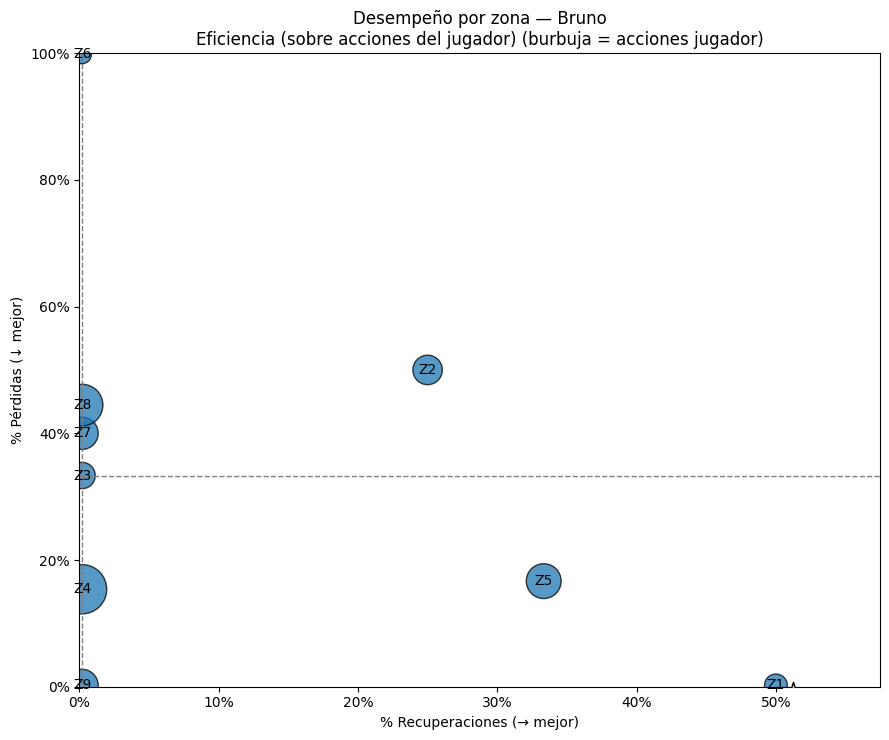

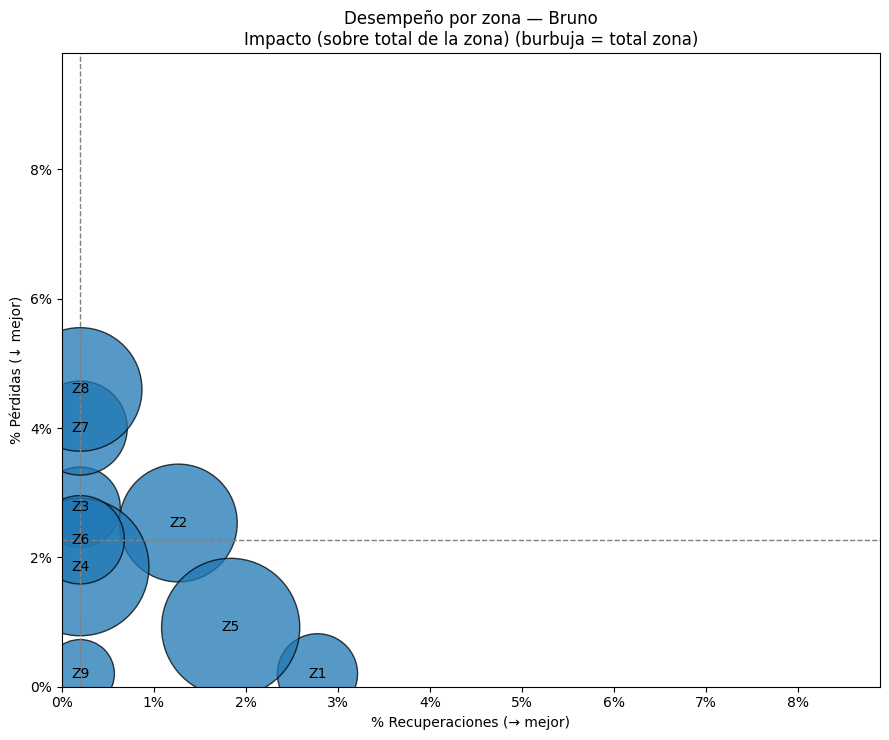

In [8]:
plot_scatter_desempeno_jugador(df_pepo, nombre_jugador="Bruno", modo="eff")
plot_scatter_desempeno_jugador(df_pepo, nombre_jugador="Bruno", modo="impacto", total_acc=total_acc)


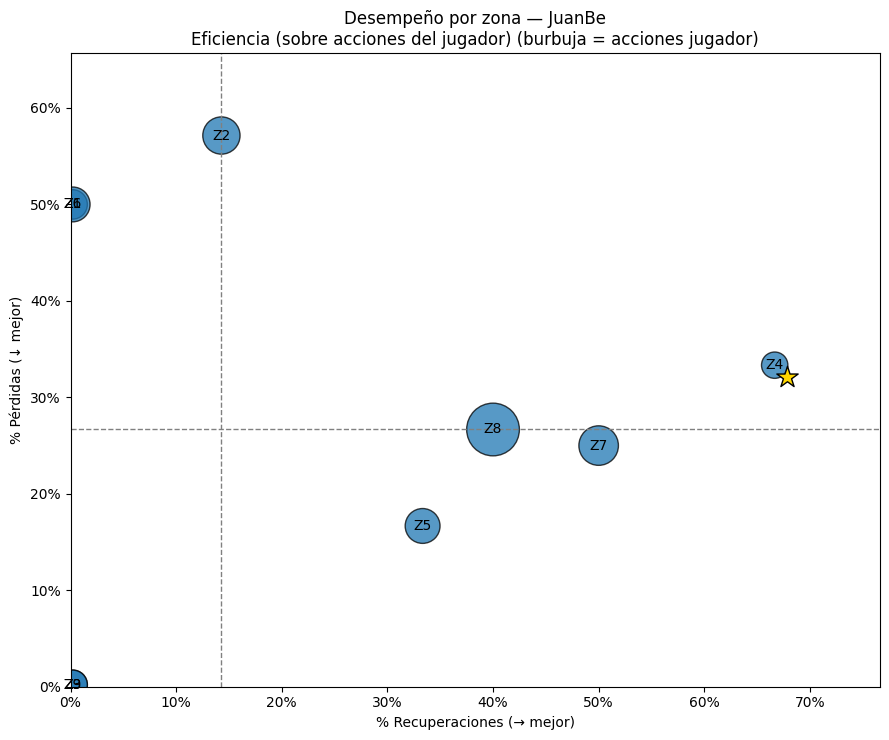

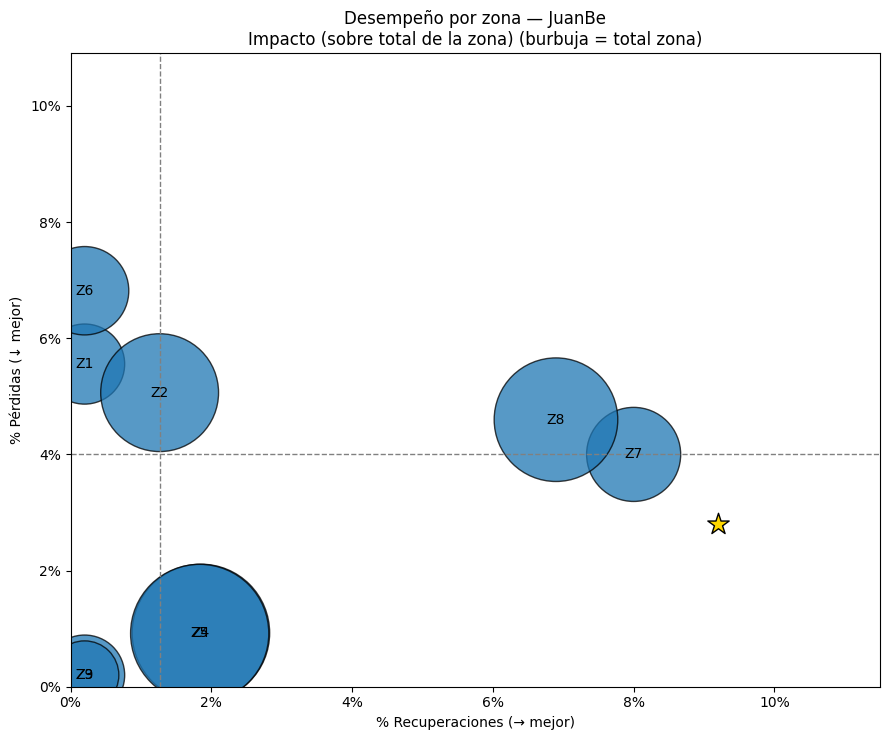

In [9]:
plot_scatter_desempeno_jugador(df_registros, nombre_jugador="JuanBe", modo="eff")
plot_scatter_desempeno_jugador(df_registros, nombre_jugador="JuanBe", modo="impacto", total_acc=total_acc)
